In [67]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.metrics import r2_score

In [81]:
#path = "/home/raim/Downloads/mTRAQ_WC_THP1_mac_library_04202023.tsv"
path = "/home/raim/data/mistrans/processedData/saap_context.tsv"
df = pd.read_csv(path, delimiter='\t')
distinct_df = pd.DataFrame(df)
#distinct_df = original_df.drop_duplicates(subset='transition_group_id')

In [82]:
print(distinct_df['peptide'])

0        GSKAAAANLCGDVILAIDGF
1        VILAIDGFGTSMTHADAQDR
2        APAPEEEMDEEQALAAEPKA
3        AAAPAPEEEMECEQALAAEP
4        AAPAPVSEAVRTSMCSIQSA
                 ...         
10005    HYVGGFYGGCEALMKLELVH
10006    HLRSYKYYTDIVNPDGFAGF
10007    LRYYTSASGDMVSLKDYCTR
10008    GRYYWGGQYTDMAKHGTDDG
10009    HAANPNGRYYGGQYTWDMAK
Name: peptide, Length: 10010, dtype: object


In [83]:
peptide_sequence = "ACDEFGHIKLMNPQRSTVWYXUZacdefghiklmnpqrstvwyxuz"   # define peptide sequence as a string 
max_sequence_length = 20    # set the maximum sequence length
num_amino_acids = 23      # number of possible amino acids

# create a dictionary to map amino acids to their indices
amino_acid_to_index = {aa: i for i, aa in enumerate(peptide_sequence)}

def one_hot_encode_sequence(sequence):
    one_hot_sequence = np.zeros((max_sequence_length, num_amino_acids), dtype=np.float32)
    for i, aa in enumerate(sequence[:max_sequence_length]):
        aa_index = amino_acid_to_index.get(aa.upper(), None)
        if aa_index is not None:
            one_hot_sequence[i, aa_index] = 1.0
    return one_hot_sequence
    
X_peptide = [one_hot_encode_sequence(seq) for seq in distinct_df['peptide']]


In [84]:
print(distinct_df['median'].values)

[-1.66926474 -2.7399428  -0.42256248 ... -2.05512912 -2.87089394
 -2.49189938]


In [85]:


# concatenate peptide sequences 
#X = [np.concatenate((X_peptide[i], np.tile(X_charge[i], (max_sequence_length, 1))), axis=1) for i in range(len(X_peptide))]
X = X_peptide
Y = distinct_df['median'].values
#weights = distinct_df['Ms1ProfileCorr'].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test, weights_train, weights_test = train_test_split(X, Y, weights, test_size=0.1, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [86]:
def weighted_mean_absolute_error(y_true, y_pred, weights):
    """
    Weighted Mean Absolute Error custom loss function.

    :param y_true: True labels
    :param y_pred: Predicted labels
    :param weights: Weights for each sample (based on Ms1ProfileCorr)
    :return: Weighted MAE
    """
    # Calculate the absolute error
    error = tf.abs(y_pred - y_true)
    transformed_weights = weights+0.1

    # Apply weights
    weighted_error = error * transformed_weights
    
    # Return the mean of the weighted error
    return tf.reduce_mean(weighted_error)

In [87]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(max_sequence_length, num_amino_acids)),
    tf.keras.layers.Dense(300, activation='swish'),
    tf.keras.layers.Dense(220, activation='swish'),
    tf.keras.layers.Dense(160, activation='swish'),
    tf.keras.layers.Dense(100, activation='swish'),
    tf.keras.layers.Dense(50, activation='swish'),
    tf.keras.layers.Dense(10, activation='swish'),
    tf.keras.layers.Dense(1, activation='linear') 
])

# compile
#model.compile(optimizer='adam', loss=lambda y_true, y_pred: weighted_mean_absolute_error(y_true, y_pred, weights))
model.compile(optimizer='adam', loss='mse')  # Customize loss function for your task

# train
model.fit(np.array(X_train), Y_train, epochs=3, batch_size=32, validation_split=0.1)

# predict
Y_pred = model.predict(np.array(X_test))
Y_pred = Y_pred.flatten()

# evaluate the model
mse = np.mean((Y_pred - Y_test) ** 2)
print("Mean Squared Error:", mse)

mae = np.mean(np.abs(Y_pred - Y_test))
print("Mean Absolute Error:", mae)

med_ae = np.median(np.abs(Y_pred - Y_test))
print("Median Absolute Error:", med_ae)

coefficient_of_dermination = r2_score(Y_test, Y_pred)
print("R-squared: ",coefficient_of_dermination)

#model.save(f'IM_model')

Epoch 1/3


/home/raim/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.0371 - val_loss: 1.5274
Epoch 2/3
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4169 - val_loss: 1.5230
Epoch 3/3
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3765 - val_loss: 1.5356
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error: 1.4702109340890825
Mean Absolute Error: 0.9666166490368407
Median Absolute Error: 0.8224100613735383
R-squared:  0.04258232378779192


In [88]:
model.export(f'IM_model')


INFO:tensorflow:Assets written to: IM_model/assets


INFO:tensorflow:Assets written to: IM_model/assets


Saved artifact at 'IM_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20, 23), dtype=tf.float32, name='keras_tensor_81')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  127775374793312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775372666736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775372665504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775372672720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775372667792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775372669200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775372660400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775372669376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775372658816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775372664272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775372671312: TensorS

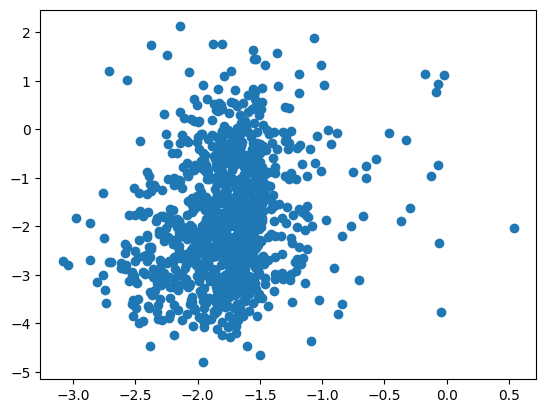

In [94]:
from matplotlib import pyplot as plt 
# Function to plot 
plt.scatter(Y_pred, Y_test) 
 
# function to show the plot 
plt.show()